In [1]:
import matplotlib.pyplot as plt

### Description:
This first cell plots the data we gathered from our entire doublet test.

Note: This control system is an integrating system and our actuator is currently on/off. Thus the actuator command is not proportional to the error right now. (We may make crane motor speed a variable quantity later.)

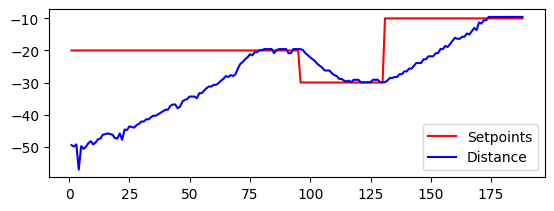

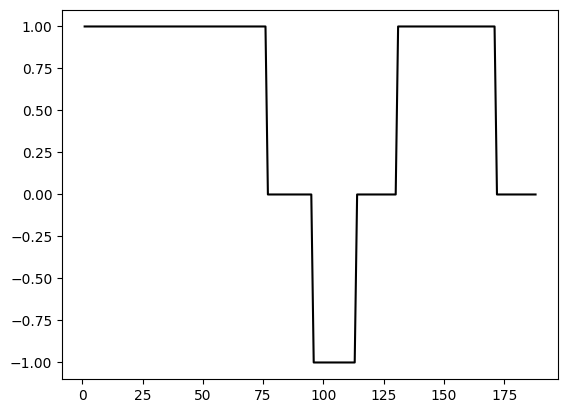

In [2]:
#modified to use Taylor's data from finaly.csv

with open("finaly.csv", "r") as f:
    times = []
    setpoints = []
    distance = []
    actuator = []

    for i, line in enumerate(f.readlines()):
        if "timestamp" in line:
            continue
        else:
            # try:
            values = line.split(",")
            setpoints.append(-1*int(values[1]))
            # if distance != None: #why this
            distance.append(-1*float(values[2]))
            # else:
            #     distance.append(0)
            # actuator.append(str(values[3])) 
            # print(str(values[3]))           
            if str(values[3]) == "raise\n":
                actuator.append(1)
            elif str(values[3]) == "lower\n":
                actuator.append(-1)
            else:
                actuator.append(0)
            times.append(i)
            # except:
                
                # break
            
plt.subplot(2, 1, 1)
plt.plot(times, setpoints, "r", label = "Setpoints")
plt.plot(times, distance, "b", label = "Distance")
plt.grid()
plt.legend()
# plt.subplot(2, 1, 2)
plt.grid()
plt.legend()
plt.show()
plt.plot(times, actuator, "k", label = "Motor Direction")


### Step Test FOPDT fit:

The below plot shows the last chunk of our doublet test, where we had one setpoint change and we watch the control response and measure its time constants. Note that the gain is incorrect - for an integrating system, gain is conceptually infinite.

Estimated gain (Kp) = 1.7269 Note - gain for integrating system is conceptually infinite.
Estimated time constant (tau_p) = 53.8399
Estimated dead time (theta_p) = 10.6991


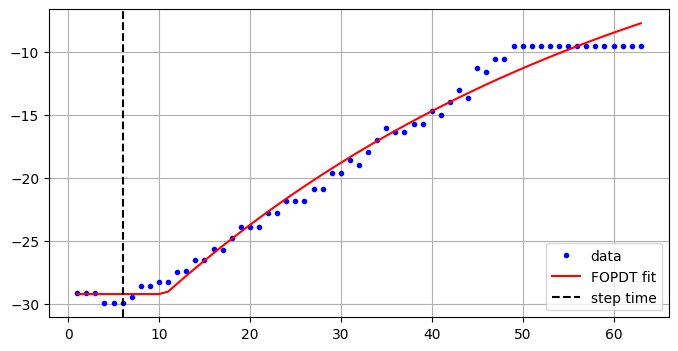

In [4]:
import numpy as np
from scipy.optimize import curve_fit

#fitting the csv data to the FOPDT model with a regression... it's gonna be very bad

with open("C:/Users/andre/OneDrive/Desktop/CH EN 436 Controls/Project/Controls-Project-Crane-Style/finaly modified.csv", "r") as f:
    times = []
    setpoints = []
    distance = []
    actuator = []

    for i, line in enumerate(f.readlines()):
        if "timestamp" in line:
            continue
        else:
            # try:
            values = line.split(",")
            setpoints.append(-1*int(values[1]))
            # if distance != None: #why this
            distance.append(-1*float(values[2]))
            # else:
            #     distance.append(0)
            # actuator.append(str(values[3])) #changing this to get number values for the actuator motion
            if str(values[3]) == "raise\n":
                actuator.append(int(1))
            elif str(values[3]) == "lower\n":
                actuator.append(int(1))
            else:
                actuator.append(0)
            times.append(i)

t = np.array(times, dtype=float)
y = np.array(distance, dtype=float)
sp = np.array(setpoints, dtype=float)

# find a step in the setpoint (use the first non-zero change or the largest change)
dsp = np.diff(sp)
if np.any(dsp != 0):
    step_idx = np.where(dsp != 0)[0][0] + 1
else:
    # fallback to largest change (or raise if truly constant)
    if np.all(dsp == 0):
        raise RuntimeError("No setpoint step detected in setpoints.")
    step_idx = np.argmax(np.abs(dsp)) + 1

t_step = t[step_idx]
delta_u = float(sp[step_idx] - sp[step_idx - 1])

# reasonable baseline and final value estimates
pre_window = max(1, min(10, step_idx))
y0 = np.mean(y[max(0, step_idx - pre_window):step_idx])
y_inf = np.mean(y[-min(20, len(y)) :])

# initial guesses
K_init = (y_inf - y0) / (delta_u if delta_u != 0 else 1.0)
# estimate deadtime: first time after step where response departs by 5% of full change
threshold = 0.05 * abs(y_inf - y0)
post_idx = np.arange(step_idx, len(y))
theta_init = 0.0
for ii in post_idx:
    if abs(y[ii] - y0) >= threshold:
        theta_init = max(0.0, t[ii] - t_step)
        break
# time constant initial: when reaches 63.2% after theta
t63_target = y0 + 0.632 * (y_inf - y0)
tau_init = (t[-1] - t_step) / 3.0
for ii in post_idx:
    if t[ii] - t_step <= theta_init:
        continue
    if (y_inf - y0) == 0:
        continue
    if (y[ii] - y0) * np.sign(y_inf - y0) >= (t63_target - y0) * np.sign(y_inf - y0):
        tau_init = max(1e-3, (t[ii] - t_step) - theta_init)
        break

# FOPDT model: y(t) = y0 + K * delta_u * (1 - exp(-(t - theta)/tau)) for t>=theta, else y0
def fopdt(t_arr, K, tau, theta, y0_param):
    t_arr = np.asarray(t_arr)
    resp = np.ones_like(t_arr) * y0_param
    t_eff = t_arr - theta
    positive = t_eff > 0
    resp[positive] = y0_param + K * delta_u * (1.0 - np.exp(-t_eff[positive] / tau))
    return resp

p0 = [K_init, max(1e-3, tau_init), max(0.0, theta_init), y0]
# bounds to keep parameters reasonable
max_t = float(t[-1] - t_step) + float(t_step)
bounds = (
    [-1000.0, 1e-6, 0.0, min(y) - 1000.0],  # lower
    [1000.0, max_t * 10.0, max_t, max(y) + 1000.0],  # upper
)

try:
    popt, pcov = curve_fit(fopdt, t, y, p0=p0, bounds=bounds, maxfev=10000)
except Exception:
    # fallback to initial estimates if fit fails
    popt = np.array(p0)

K_fit, tau_fit, theta_fit, y0_fit = popt
gain = K_fit  # process gain (y change per unit input change)
tau_p = tau_fit
theta_p = theta_fit

# print results
print(f"Estimated gain (Kp) = {gain:.4f} Note - gain for integrating system is conceptually infinite.")
print(f"Estimated time constant (tau_p) = {tau_p:.4f}")
print(f"Estimated dead time (theta_p) = {theta_p:.4f}")

# plot data and fit
y_fit = fopdt(t, K_fit, tau_fit, theta_fit, y0_fit)
plt.figure(figsize=(8,4))
plt.plot(t, y, "b.", label="data")
plt.plot(t, y_fit, "r-", label="FOPDT fit")
plt.axvline(t_step, color="k", linestyle="--", label="step time")
plt.legend()
plt.grid(True)
plt.show()